# PROJECT OVERVIEW

* Problem
    - Is All-Weather-Portfolio the best ?
* Project Purpose
    - To find a more profitable but safer asset allocation portfolio than traditional all-weather-protfolio.

## 라이브러리 및 원본데이터 로드

In [24]:
# image
from IPython.display import Image

# data processing
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# read index data
sp_index = pd.read_csv("./data/S&P_Index.csv")
gold_index = pd.read_csv("./data/Gold_Index.csv")
commodity_index = pd.read_csv("./data/Commodity_Index.csv")
interm_index = pd.read_csv("./data/Intermediate_Term_Bond_Index.csv")
long_index = pd.read_csv("./data/Long_Term_Bond_Index.csv")

# DATA PROCESSING

## Data preprocessing 관련 함수

In [26]:
def preprocessing(sp_index, gold_index, commodity_index, interm_index, long_index):
    # weekly 'close' price
    closes_df = pd.DataFrame({'Date': sp_index["Date"].copy(),
                              'SP_Close': sp_index["Close"].copy(),
                              'Long_Close': long_index["Close"].copy(),
                              'Interm_Close': interm_index["Close"].copy(),
                              'Commodity_Close': commodity_index["Close"].copy(),
                              'Gold_Close': gold_index["Close"].copy()}).round(2)
    
    # set 'Date' columns as an index 
    
    closes_df['Date'] = pd.to_datetime(closes_df['Date'])
    closes_df = closes_df.set_index('Date', drop=True)
    
    # : current week's return compared to return a week before
    index_df = (closes_df - closes_df.shift(1)) / closes_df.shift(1)
    
    # : current week's return compared to return of the first week
    cumul_index_df = (closes_df - closes_df.iloc[0]) / closes_df.iloc[0]
    
    return closes_df, index_df, cumul_index_df



## BackTesting 관련 함수

In [27]:
def get_port_return(w1, w2, w3, w4, w5):
    return (index_df * [w1, w2, w3, w4, w5]).sum(axis=1)

def get_port_cumul_return(w1, w2, w3, w4, w5):
    return (cumul_index_df * [w1, w2, w3, w4, w5]).sum(axis=1)

# 연간 수익률이 + 인 년도의 비율
def win_year(data_weekly_profit):
    year_profit = data_weekly_profit.resample("Y").sum()
    profit = year_profit[year_profit>0].count()/year_profit.count()*100
    return profit

# 각 인덱스 or ETF 당 백테스팅 결과
def backtest_func(name, data_weekly_profit, data_cumul_profit):
    """
    input: 시리즈 형태의 index or ETF의 종가, 주간 수익률, 누적수익률 
    output: 딕셔너리 형태의 backtesting 결과
    """
    
    ls = {}
    ls["Name"] = name
    ls["Start"] = data_weekly_profit.index[0].strftime("%Y-%m-%d")
    ls["End"] = data_weekly_profit.index[-1].strftime("%Y-%m-%d")
    year_profit = data_weekly_profit.resample("Y").sum()
    risk_free_rate = 1/100
    
    
    ls['Total Return'] = str(round(data_cumul_profit.loc["2020-06-29"]*100,2))+" %"
    ls['CAGR'] = str(round(data_cumul_profit.loc["2020-06-29"]*100/25,2))+ " %"
    ls["Negative Week"] = data_weekly_profit[data_weekly_profit<0].count()
    
    ls["Weekly Mean"]= str(round(data_weekly_profit.mean()*100,2))+" %"
    ls["Weekly Vol"]= str(round(data_weekly_profit.std()*100, 2))+" %"
    ls['Best Week']= str(round(data_weekly_profit.max()*100,2))+" %"
    ls['Worst Week'] = str(round(data_weekly_profit.min()*100,2))+" %"
    
    ls["Monthly Mean"] = str(round(data_weekly_profit.resample("M").sum().mean()*100,2))+" %"
    ls["Monthly Vol"] = str(round(data_weekly_profit.resample("M").sum().std()*100, 2))+" %"
    ls['Best Month']= str(round(data_weekly_profit.resample("M").sum().max()*100,2))+" %"
    ls['Worst Month']= str(round(data_weekly_profit.resample("M").sum().min()*100,2))+" %"
    
    ls["Yearly Mean"]= str(round(data_weekly_profit.resample("Y").sum().mean()*100,2))+" %"
    ls["Yearly Vol"]= str(round(data_weekly_profit.resample("Y").sum().std()*100, 2))+" %"
    ls['Best Year']=str(round(data_weekly_profit.resample("Y").sum().max()*100,2))+" %"
    ls['Worst Year']= str(round(data_weekly_profit.resample("Y").sum().min()*100,2))+" %"
    
    ls["Average Drawdown"] = str(round(data_weekly_profit[data_weekly_profit<0].mean()*100,2))+" %"
    ls["Average Drawdown weeks"]= data_weekly_profit[data_weekly_profit<0].resample("Y").count().mean()
    ls["Average Up Month"] = str(round(data_weekly_profit[data_weekly_profit>0].resample("M").sum().mean()*100,2))+" %"
    ls["Average Down Month"] = str(round(data_weekly_profit[data_weekly_profit<0].resample("M").sum().mean()*100,2))+" %"
    ls["Win Year %"] = win_year(data_weekly_profit)
    
    return ls

# 전체 데이터 백테스팅 함수
def total_backtest(df_weekly_profit, df_cumul_profit):
    """
    input: 주간 수익률 데이터 프레임, 누적 수익률 데이터 프레임
    output: backtest 결과
    """
    targets = df_weekly_profit.columns.values.tolist()
    data_backtest=[]
    for target in targets:
        target_backtest = backtest_func(target,df_weekly_profit[target], df_cumul_profit[target])
        data_backtest.append(target_backtest)
        
    data_backtest = pd.DataFrame(data_backtest)
    data_backtest.set_index("Name", drop=True, inplace=True)

    return data_backtest.T

## 지수별 EDA

In [28]:
closes_df, index_df, cumul_index_df = preprocessing(sp_index, gold_index, commodity_index, interm_index, long_index)

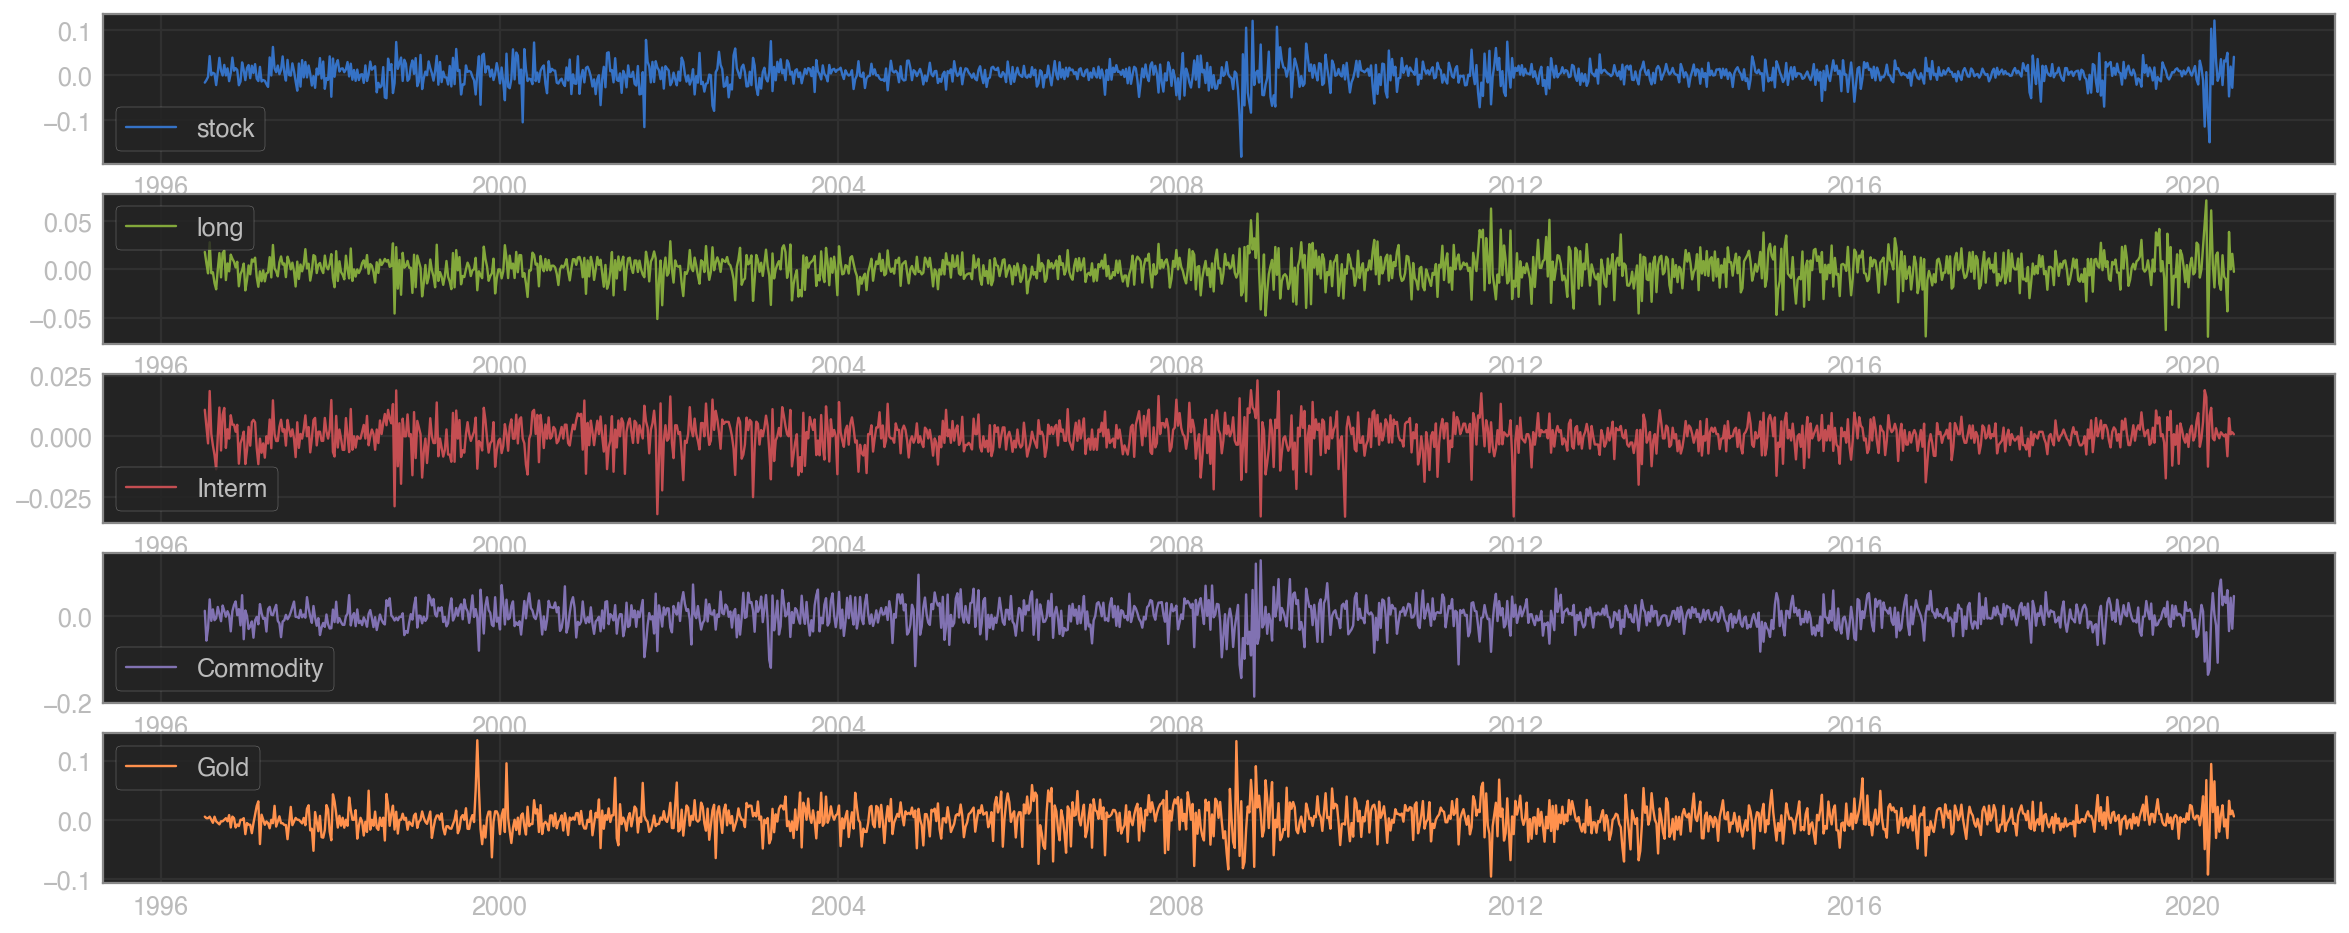

In [29]:
# rate of weekly return(rwr)
# comparing rcr by asset types
plt.figure(figsize=(20, 8))

plt.subplot(511)
plt.plot(index_df.index, index_df.SP_Close, label="stock",color="b")
plt.grid(True)
plt.legend()

plt.subplot(512)
plt.plot(index_df.index, index_df.Long_Close, label="long",color="g")
plt.grid(True)
plt.legend()

plt.subplot(513)
plt.plot(index_df.index, index_df.Interm_Close, label="Interm",color="r")
plt.grid(True)
plt.legend()

plt.subplot(514)
plt.plot(index_df.index, index_df.Commodity_Close, label="Commodity",color="m")
plt.grid(True)
plt.legend()

plt.subplot(515)
plt.plot(index_df.index, index_df.Gold_Close, label="Gold", color="y")
plt.grid(True)
plt.legend()
#plt.xticks(index_df.index[::105])
# plt.axis(["1996-07-01", "2020-06-29", -1, 5])

plt.show()

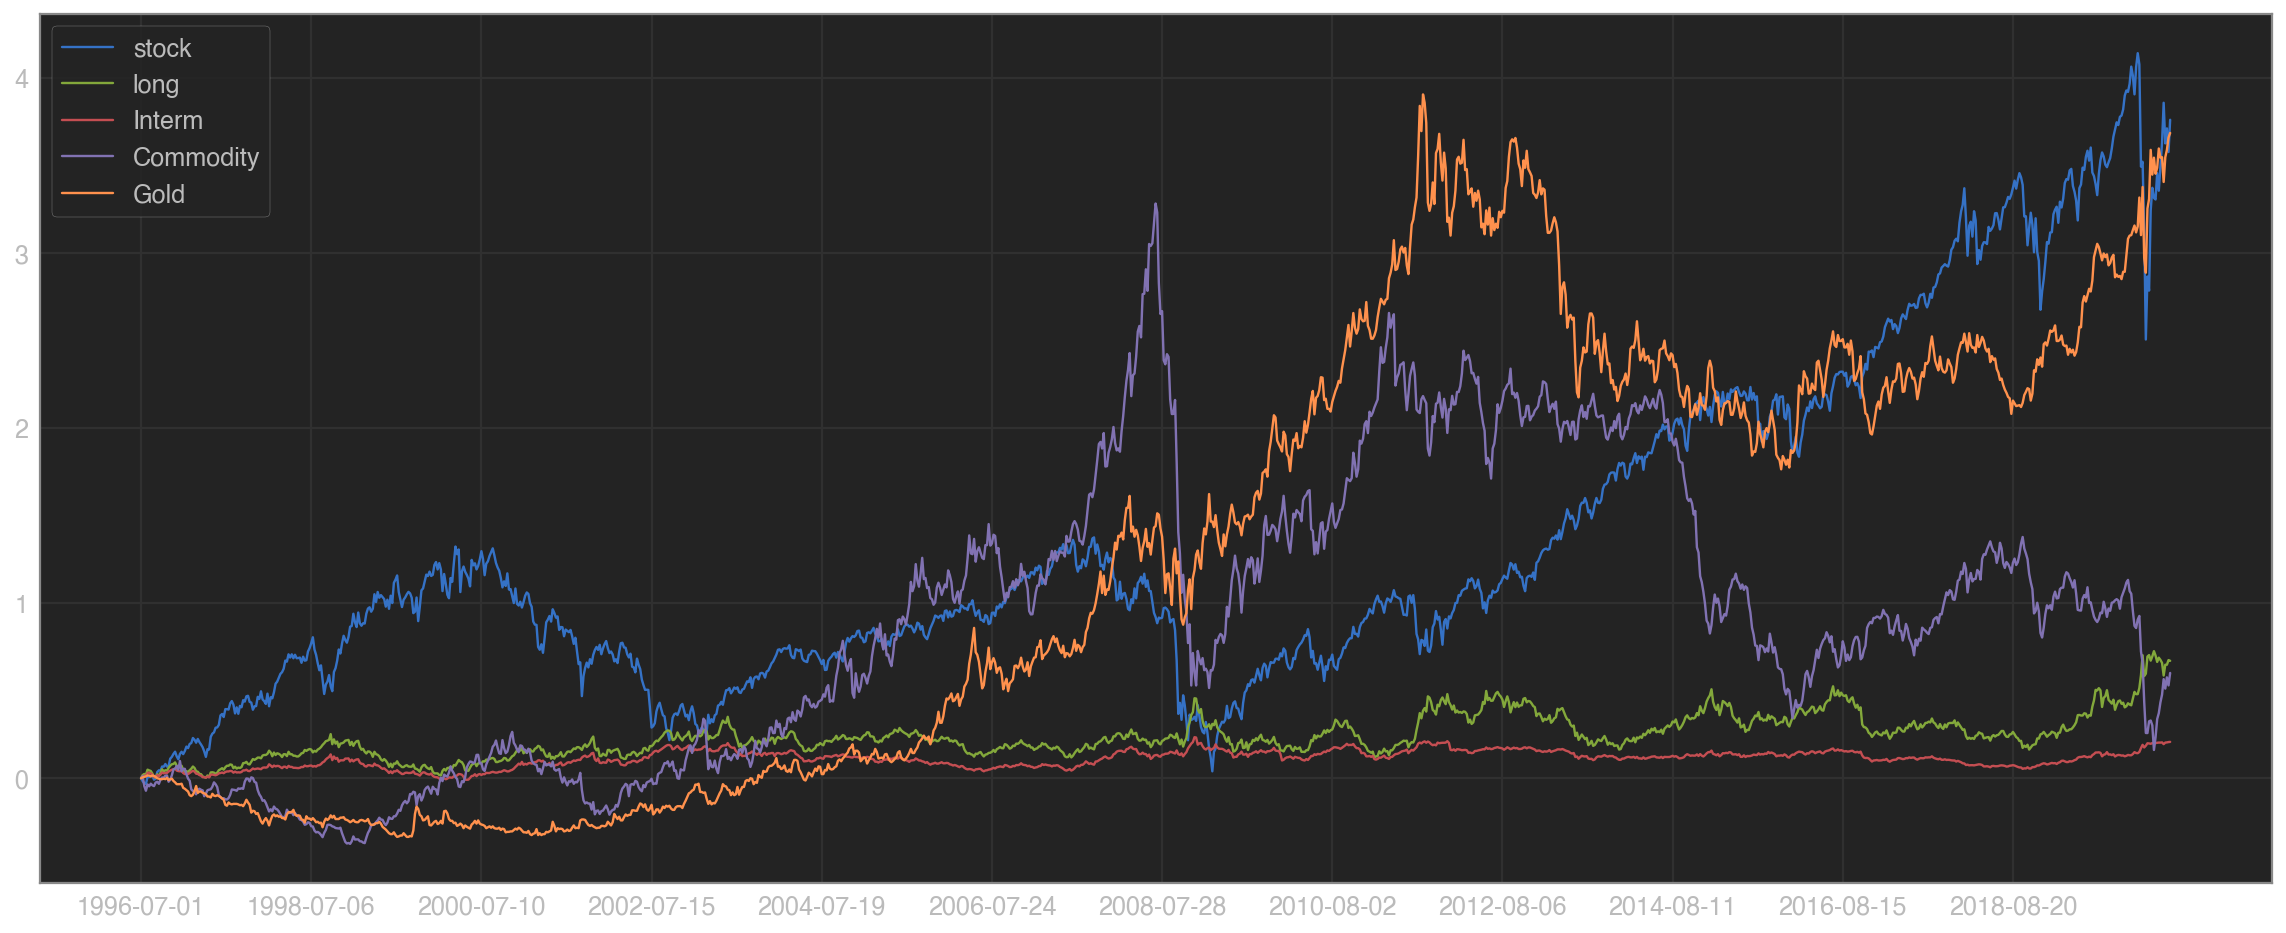

In [30]:
# rate of cumulative return (rcr)
# comparing rcr by asset types
plt.figure(figsize=(20, 8))

plt.plot(cumul_index_df.index, cumul_index_df.SP_Close, label="stock")
plt.plot(cumul_index_df.index, cumul_index_df.Long_Close, label="long")
plt.plot(cumul_index_df.index, cumul_index_df.Interm_Close, label="Interm")
plt.plot(cumul_index_df.index, cumul_index_df.Commodity_Close, label="Commodity")
plt.plot(cumul_index_df.index, cumul_index_df.Gold_Close, label="Gold")

plt.xticks(cumul_index_df.index[::105])
# plt.axis(["1996-07-01", "2020-06-29", -1, 5])

plt.grid(True)
plt.legend()
plt.show()

## PORTFOLIO 구성
- portfolio_1 : stock 100%
- portfolio_2 : stock 60% + long-term bond 40%
- portfolio_3 : All_Weather : stock 30% + long-term bond 40% + mid-term bond 15% + commidity 7.5% + gold 7.5%

In [31]:
# asset allocation portfolio
equity_names = ["Stock", "Long_bond", "Interm_bond", "Commodity", "Gold"]
# stock 100%
stock100 = [1, 0, 0, 0, 0]
# stock 60% + long-term bond 40%
s6_b4 = [0.6, 0.4, 0, 0, 0]
# stock 30% + long-term bond 40% + mid-term bond 15% + commidity 7.5% + gold 7.5%
all_weather = [0.3, 0.4, 0.15, 0.075, 0.075]

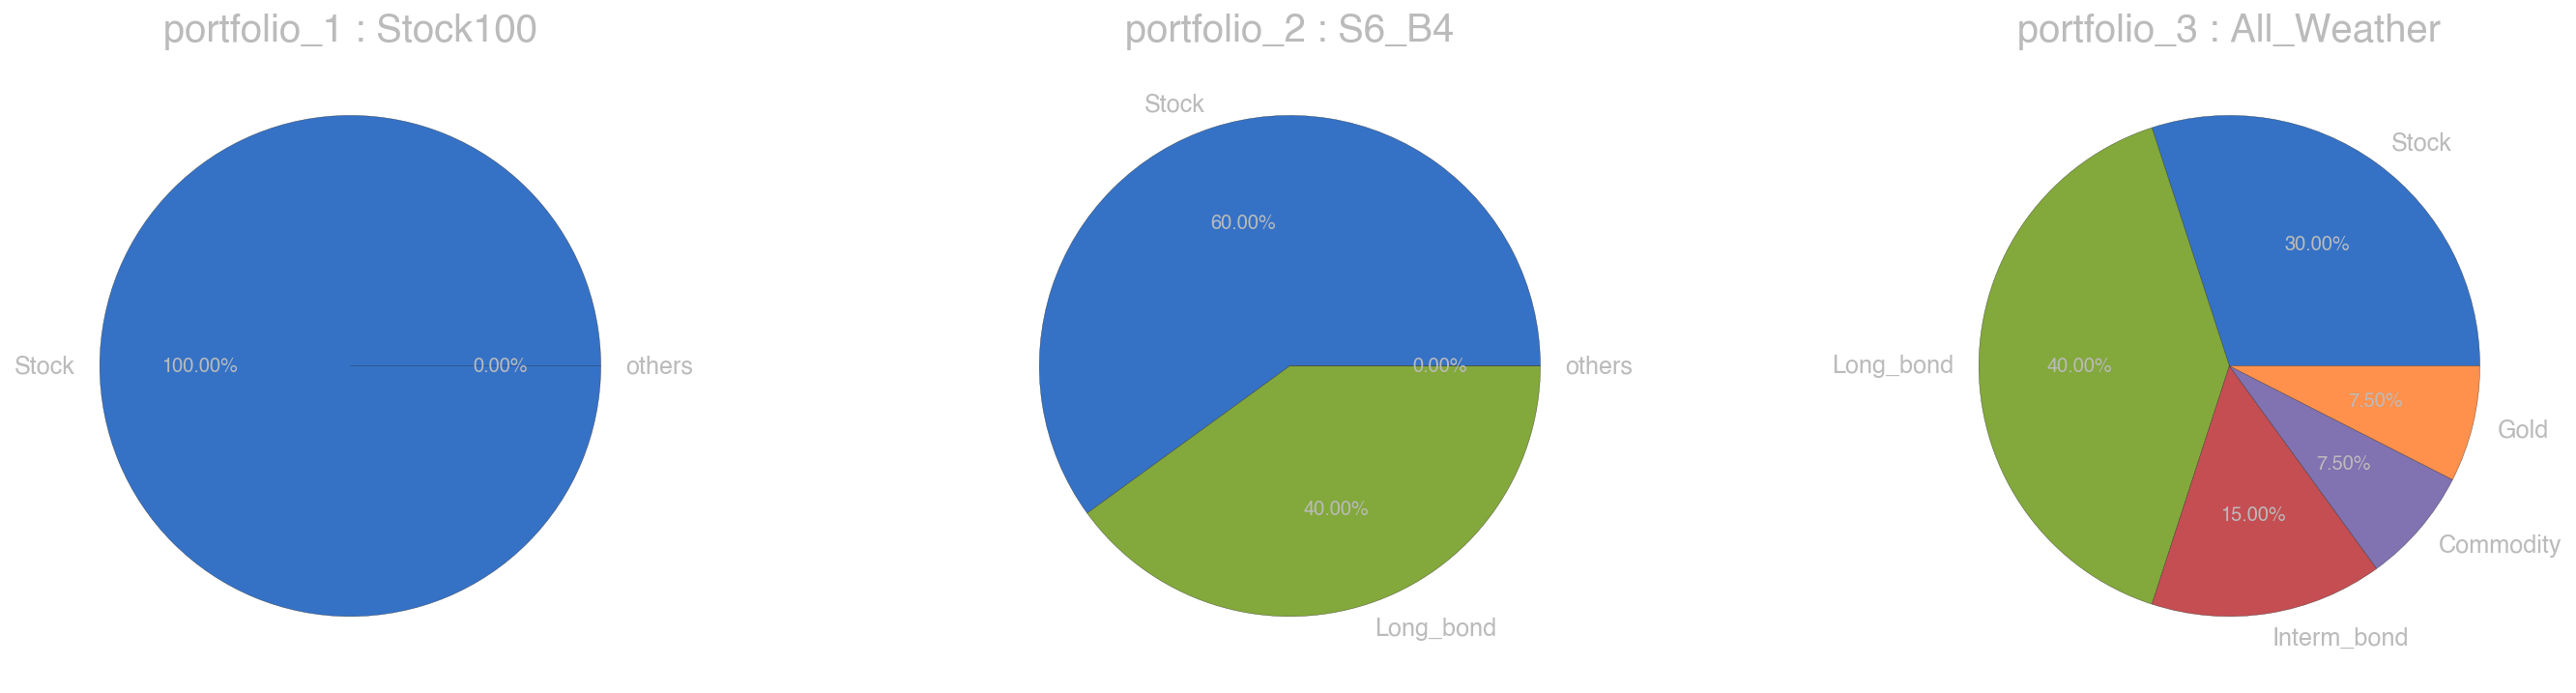

In [32]:
# pie graph for asset allocation portfolio
plt.figure(figsize=(20, 8))

# 1. stock 100%
data1 = stock100[:1] + [0]
data2 = equity_names[:1] + ["others"]

plt.subplot(131)
plt.pie(data1, labels=data2, autopct='%0.2f%%')
plt.title('portfolio_1 : Stock100', fontsize=20)

# 2. stock 60% + long-term bond 40%
data3 = s6_b4[:2] + [0]
data4 = equity_names[:2] + ["others"]

plt.subplot(132)
plt.pie(data3, labels=data4, autopct='%0.2f%%')
plt.title('portfolio_2 : S6_B4', fontsize=20)

# 3. All_Weather
plt.subplot(133)
plt.pie(all_weather, labels=equity_names, autopct='%0.2f%%')
plt.title('portfolio_3 : All_Weather', fontsize=20)

plt.subplots_adjust(top=1, bottom=0.1, left=0.1,
                    right=1, hspace=0.5, wspace=0.5)

In [33]:
# analysis about rwr by the porfolios
# portfolio_1 : Stock100
df_stock100 = pd.DataFrame({"Stock100": get_port_return(*stock100)})

# portfolio_2 : S6_B4
df_s6_b4 = pd.DataFrame({"S6_B4": get_port_return(*s6_b4)})

# portfolio_3 : All_Weather
df_all_weather = pd.DataFrame({"All_Weather": get_port_return(*all_weather)})

port_df = pd.DataFrame({"Stock100": df_stock100["Stock100"],
                        "S6_B4": df_s6_b4["S6_B4"],
                        "All_Weather": df_all_weather["All_Weather"]
                        })
port_df

,Stock100,S6_B4,All_Weather
Date,,,
1996-07-01,0.000000,0.000000,0.000000
1996-07-08,-0.017112,-0.003041,0.005048
1996-07-15,-0.011545,-0.004422,-0.004415
1996-07-22,-0.004431,-0.004318,-0.005323
1996-07-29,0.041815,0.036339,0.029883
...,...,...,...
2020-06-01,0.049147,0.012064,-0.001740
2020-06-08,-0.047784,-0.013131,0.002138
2020-06-15,0.018555,0.011133,0.009569


In [34]:
# analysis about rcr by the porfolios
df_cul_stock100 = pd.DataFrame({"Stock100": get_port_cumul_return(*stock100)})
df_cul_s6_b4 = pd.DataFrame({"S6_B4": get_port_cumul_return(*s6_b4)})
df_cul_all_weather = pd.DataFrame(
    {"All_Weather": get_port_cumul_return(*all_weather)})

port_cul_df = pd.DataFrame({"Stock100": df_cul_stock100["Stock100"],
                            "S6_B4": df_cul_s6_b4["S6_B4"],
                            "All_Weather": df_cul_all_weather["All_Weather"]
                            })

port_cul_df

,Stock100,S6_B4,All_Weather
Date,,,
1996-07-01,0.000000,0.000000,0.000000
1996-07-08,-0.017112,-0.003041,0.005048
1996-07-15,-0.028459,-0.007298,0.000693
1996-07-22,-0.032763,-0.011582,-0.004545
1996-07-29,0.007681,0.024162,0.024984
...,...,...,...
2020-06-01,3.858132,2.549523,1.719161
2020-06-08,3.625989,2.434892,1.682053
2020-06-15,3.711822,2.486392,1.715913


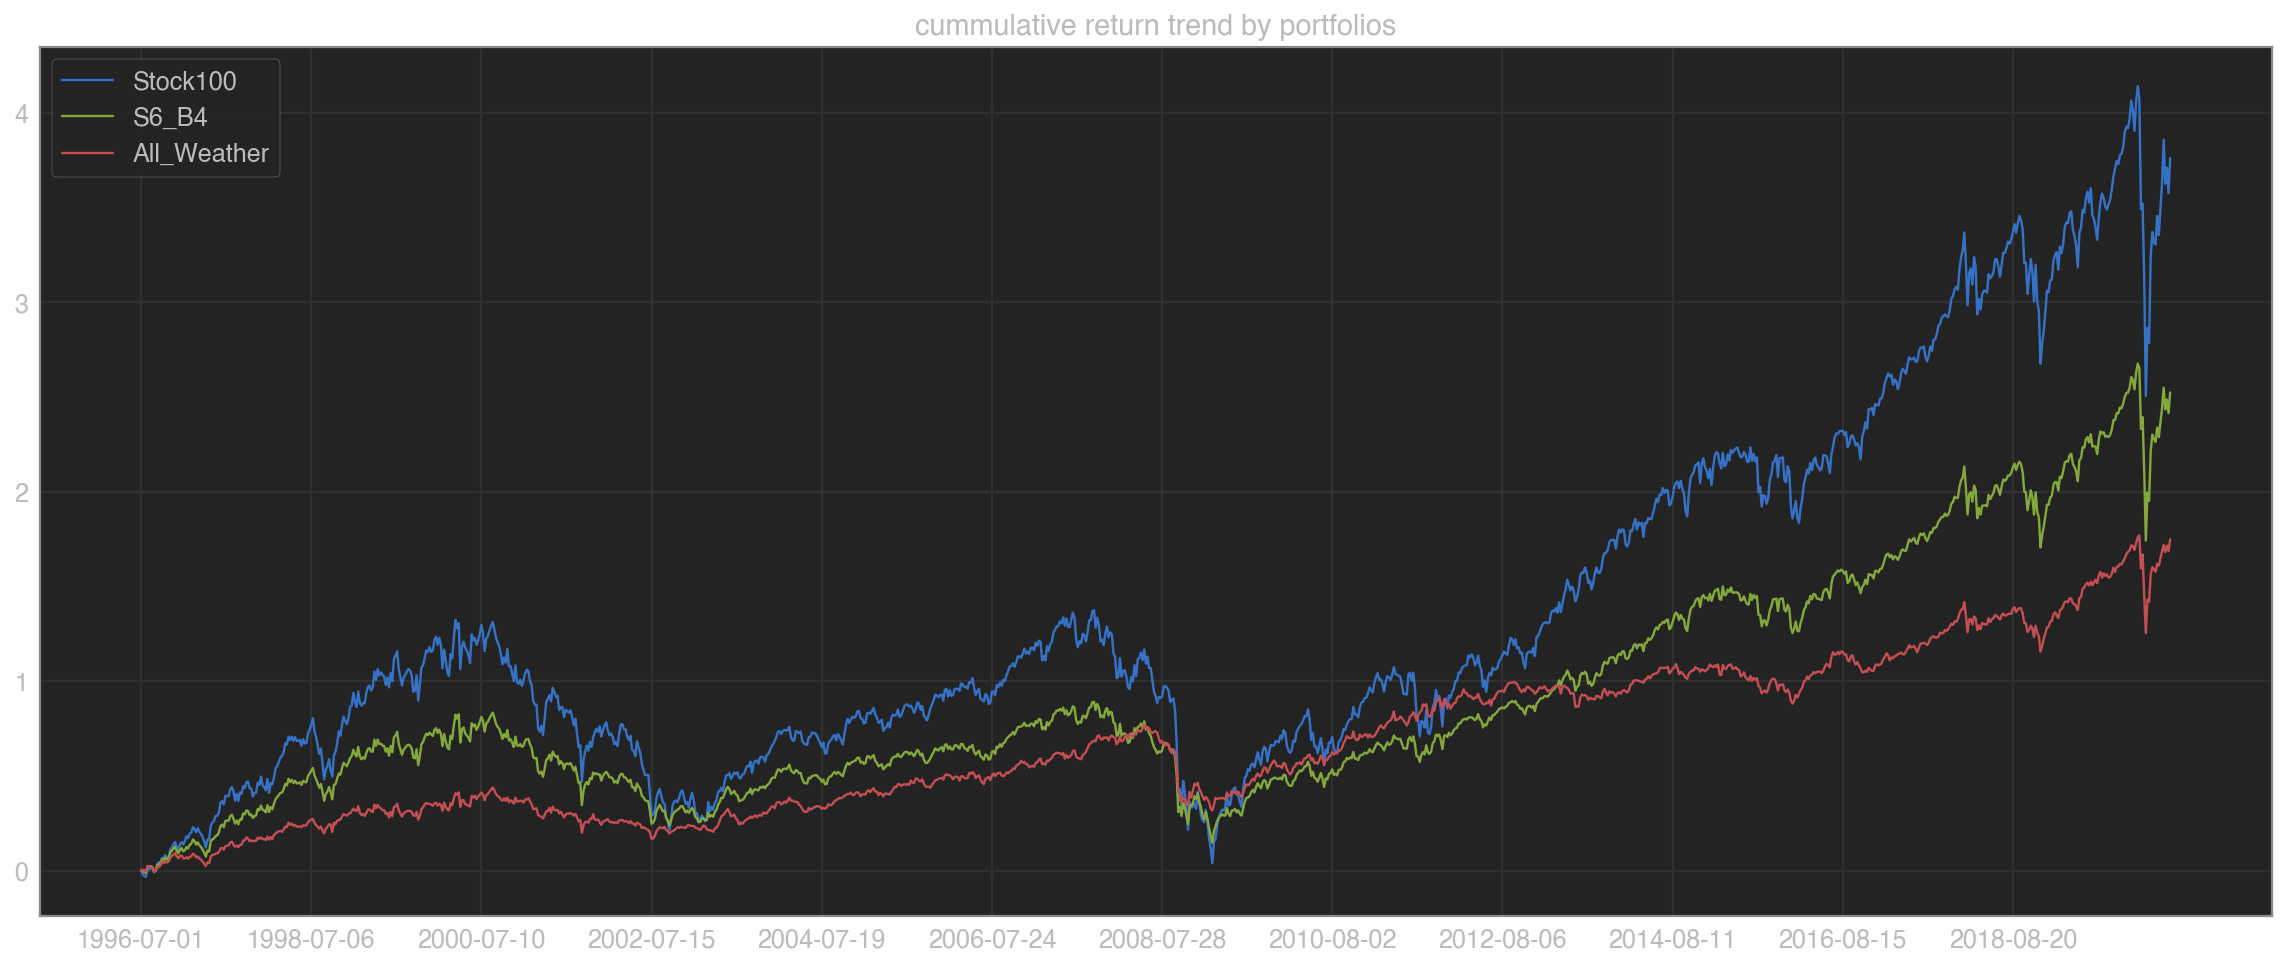

In [35]:
# trend analysis about rcr by the porfolios
plt.figure(figsize=(20, 8))

plt.plot(port_cul_df.index, port_cul_df.Stock100, label="Stock100")
plt.plot(port_cul_df.index, port_cul_df.S6_B4, label="S6_B4")
plt.plot(port_cul_df.index, port_cul_df.All_Weather, label="All_Weather")

plt.xticks(cumul_index_df.index[::105])

plt.title('cummulative return trend by portfolios')
plt.grid(True)
plt.legend()
plt.show()

**BACKTEST RESULT**

> - All_weather portfolio doesn't seem to be the best portfolio to invest since the rate of cumulative return is 170% over the last 25 years even though it's safer than any others. 
> - Therefore, we think that it would be valuable to build a new portfolio that is able to make more returns as maintaining the safeness of All_Weather portfolio.

##  NEW ALL WEATHER PORTFOLIO
- increasing the weight of the assets which are more correlated with SP_500(stock) 

<AxesSubplot:>

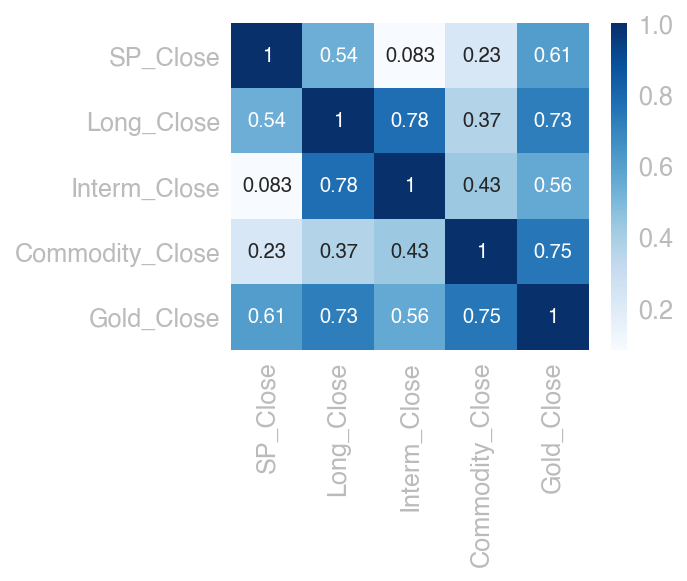

In [36]:
# analyze the correlation
plt.figure(figsize=(4, 3))
sns.heatmap(data=cumul_index_df.corr(), annot=True, cmap="Blues")

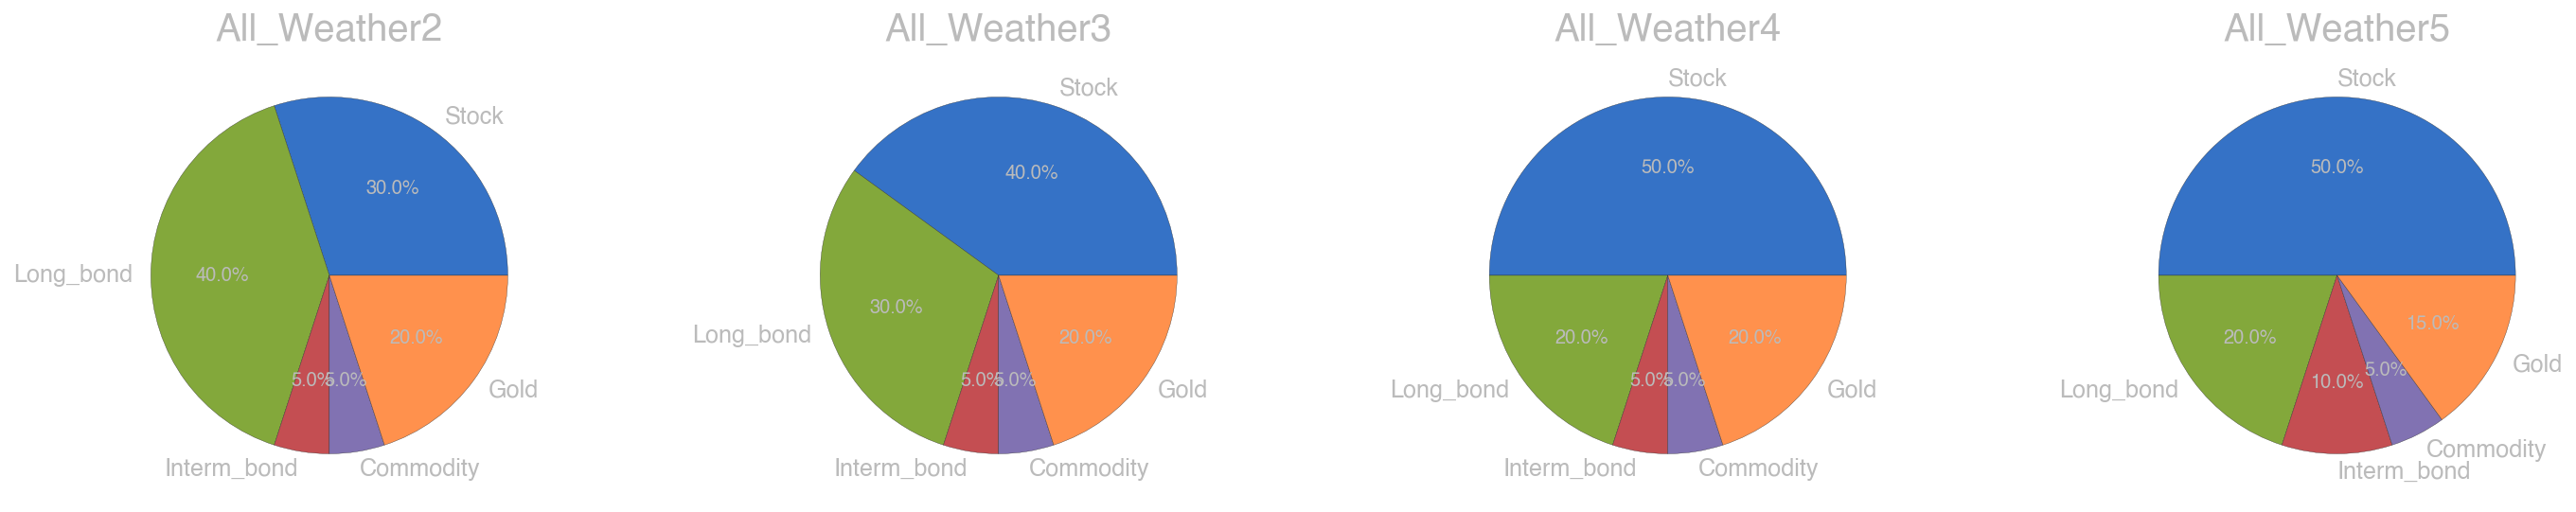

In [37]:
# increase the weight of the assets which are highly correlated with SP_500(stock)

# all_weather2 : interm(-0.1), commodity(-0.025), gold(+0.125)
all_weather2 = [0.3, 0.4, 0.05, 0.05, 0.2]
# all_weather3 : long(-0.1), interm(-0.1), commodity(-0.025), sp(+0.1), gold(+0.125)
all_weather3 = [0.4, 0.3, 0.05, 0.05, 0.2]
# all_weather4 : long(-0.2), interm(-0.1), commodity(-0.025), sp(+0.2), gold(+0.125)
all_weather4 = [0.5, 0.2, 0.05, 0.05, 0.2]
# all_weather5 : long(-0.2), interm(-0.1), commodity(-0.025), sp(+0.2), gold(0.075)
all_weather5 = [0.5, 0.2, 0.1, 0.05, 0.15]

# pie graph for the new all weather portfolio

plt.figure(figsize=(20, 8))

plt.subplot(141)
plt.pie(all_weather2, labels=equity_names, autopct='%0.1f%%')
plt.title('All_Weather2', fontsize=20)

plt.subplot(142)
plt.pie(all_weather3, labels=equity_names, autopct='%0.1f%%')
plt.title('All_Weather3', fontsize=20)

plt.subplot(143)
plt.pie(all_weather4, labels=equity_names, autopct='%0.1f%%')
plt.title('All_Weather4', fontsize=20)

plt.subplot(144)
plt.pie(all_weather5, labels=equity_names, autopct='%0.1f%%')
plt.title('All_Weather5', fontsize=20)


plt.subplots_adjust(top=1, bottom=0.1, left=0.1,
                    right=1, hspace=0.5, wspace=0.5)

In [38]:
# rwr analysis
df_all_weather2 = pd.DataFrame(
    {"All_Weather2": get_port_return(*all_weather2)})
df_all_weather3 = pd.DataFrame(
    {"All_Weather3": get_port_return(*all_weather3)})
df_all_weather4 = pd.DataFrame(
    {"All_Weather4": get_port_return(*all_weather4)})
df_all_weather5 = pd.DataFrame(
    {"All_Weather5": get_port_return(*all_weather5)})

port_df = pd.DataFrame({"Stock100": df_stock100["Stock100"],
                        "S6_B4": df_s6_b4["S6_B4"],
                        "All_Weather": df_all_weather["All_Weather"],
                        "All_Weather2": df_all_weather2["All_Weather2"],
                        "All_Weather3": df_all_weather3["All_Weather3"],
                        "All_Weather4": df_all_weather4["All_Weather4"],
                        "All_Weather5": df_all_weather5["All_Weather5"]
                        })
port_df.tail(2)

,Stock100,S6_B4,All_Weather,All_Weather2,All_Weather3,All_Weather4,All_Weather5
Date,,,,,,,
2020-06-22,-0.028631,-0.010731,-0.002925,-0.000436,-0.004911,-0.009386,-0.010074
2020-06-29,0.040199,0.023104,0.015072,0.014531,0.018804,0.023078,0.022838


In [39]:
# rcr
df_cul_all_weather2 = pd.DataFrame(
    {"All_Weather2": get_port_cumul_return(*all_weather2)})
df_cul_all_weather3 = pd.DataFrame(
    {"All_Weather3": get_port_cumul_return(*all_weather3)})
df_cul_all_weather4 = pd.DataFrame(
    {"All_Weather4": get_port_cumul_return(*all_weather4)})
df_cul_all_weather5 = pd.DataFrame(
    {"All_Weather5": get_port_cumul_return(*all_weather5)})

port_cul_df = pd.DataFrame({"Stock100": df_cul_stock100["Stock100"],
                            "S6_B4": df_cul_s6_b4["S6_B4"],
                            "All_Weather": df_cul_all_weather["All_Weather"],
                            "All_Weather2": df_cul_all_weather2["All_Weather2"],
                            "All_Weather3": df_cul_all_weather3["All_Weather3"],
                            "All_Weather4": df_cul_all_weather4["All_Weather4"],
                            "All_Weather5": df_cul_all_weather5["All_Weather5"]
                            })
port_cul_df.tail(2)

,Stock100,S6_B4,All_Weather,All_Weather2,All_Weather3,All_Weather4,All_Weather5
Date,,,,,,,
2020-06-22,3.576920,2.416077,1.688223,2.111774,2.401985,2.692196,2.519539
2020-06-29,3.760906,2.524769,1.749160,2.174108,2.483142,2.792176,2.618261


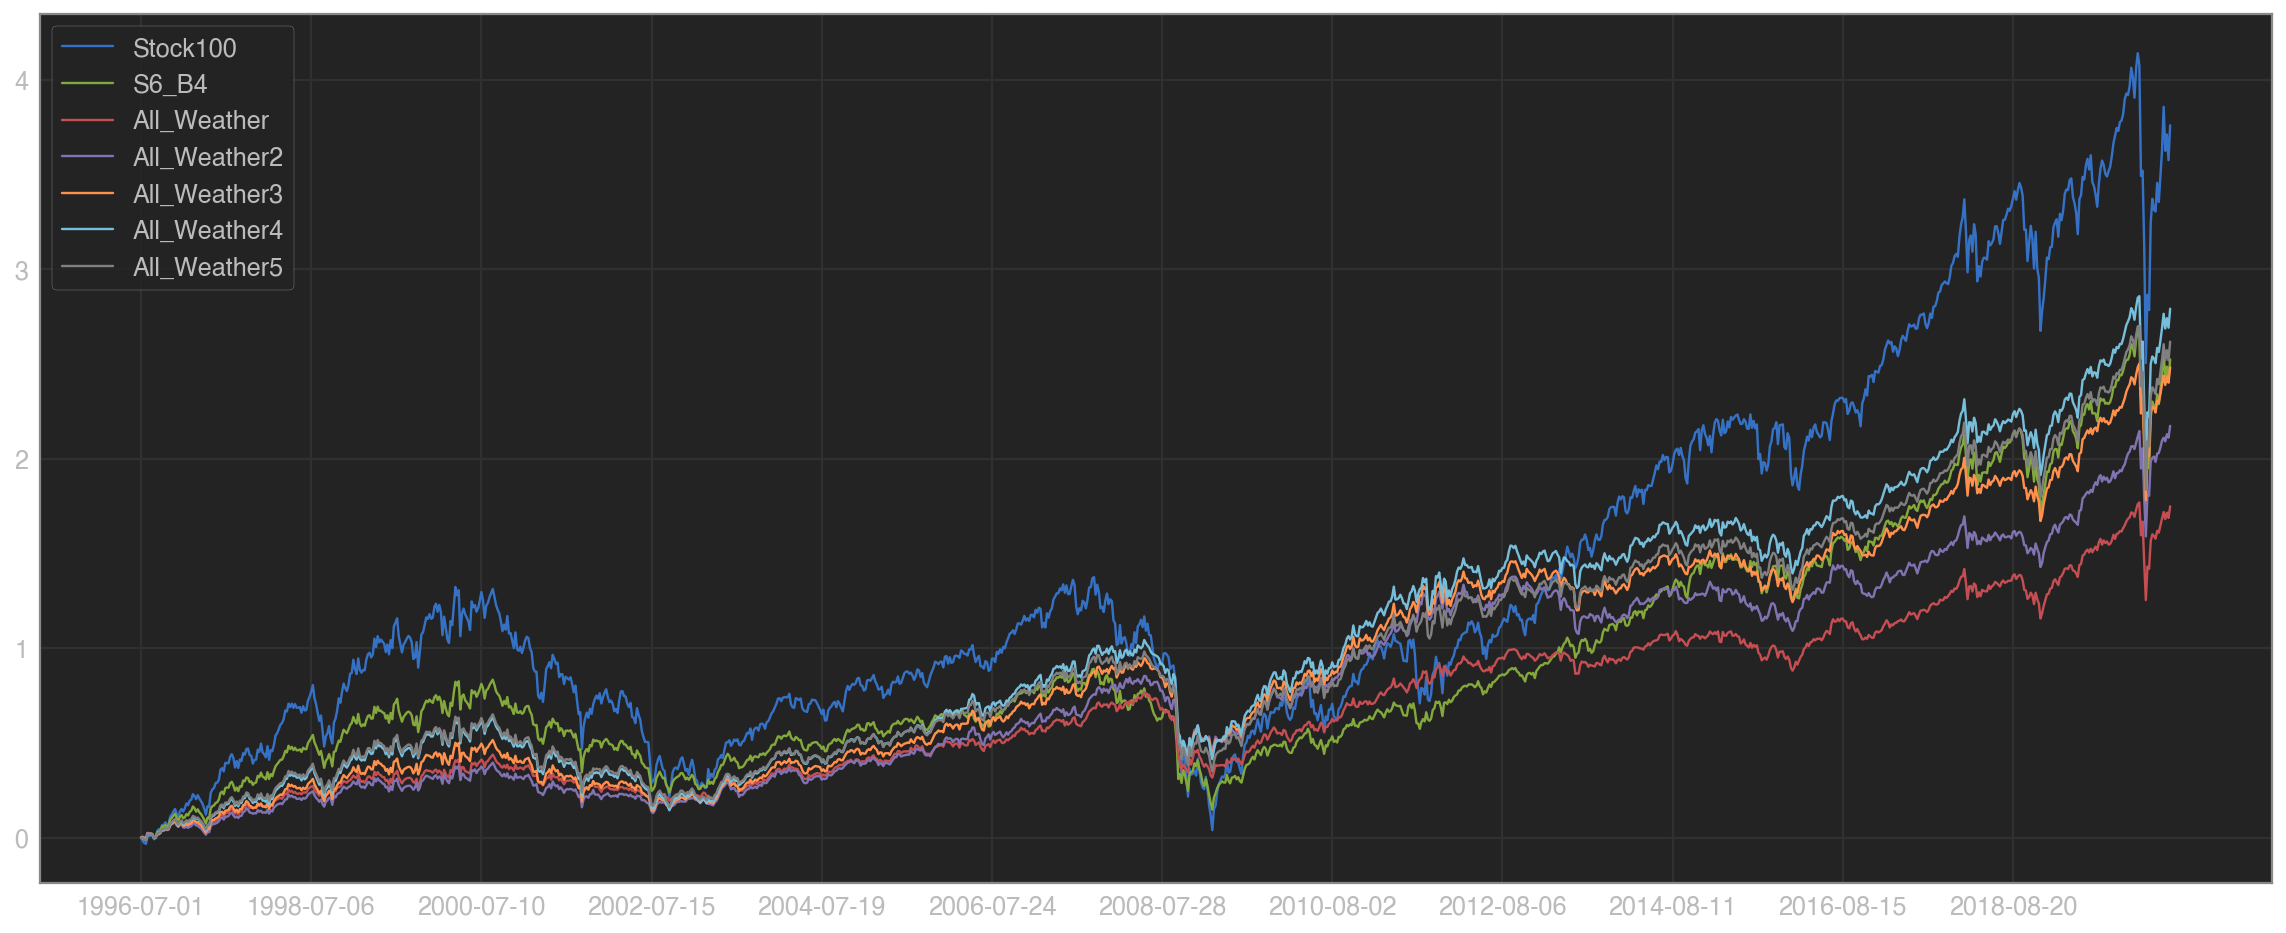

In [40]:
# crr's trend of New all_weather portfolio 
plt.figure(figsize=(20, 8))

plt.plot(port_cul_df.index, port_cul_df.Stock100, label="Stock100")
plt.plot(port_cul_df.index, port_cul_df.S6_B4, label="S6_B4")
plt.plot(port_cul_df.index, port_cul_df.All_Weather, label="All_Weather")
plt.plot(port_cul_df.index, port_cul_df.All_Weather2, label="All_Weather2")
plt.plot(port_cul_df.index, port_cul_df.All_Weather3, label="All_Weather3")
plt.plot(port_cul_df.index, port_cul_df.All_Weather4, label="All_Weather4")
plt.plot(port_cul_df.index, port_cul_df.All_Weather5,
         label="All_Weather5", color='grey')

plt.xticks(cumul_index_df.index[::105])
# plt.axis(["1996-07-01", "2020-06-29", -1, 5])

plt.grid(True)
plt.legend()
plt.show()

In [41]:
total_backtest(port_df, port_cul_df)

Name,Stock100,S6_B4,All_Weather,All_Weather2,All_Weather3,All_Weather4,All_Weather5
Start,1996-07-01,1996-07-01,1996-07-01,1996-07-01,1996-07-01,1996-07-01,1996-07-01
End,2020-06-29,2020-06-29,2020-06-29,2020-06-29,2020-06-29,2020-06-29,2020-06-29
Total Return,376.09 %,252.48 %,174.92 %,217.41 %,248.31 %,279.22 %,261.83 %
CAGR,15.04 %,10.1 %,7.0 %,8.7 %,9.93 %,11.17 %,10.47 %
Negative Week,548,561,550,561,560,548,544
Weekly Mean,0.16 %,0.11 %,0.09 %,0.1 %,0.11 %,0.12 %,0.12 %
Weekly Vol,2.49 %,1.46 %,0.98 %,1.07 %,1.19 %,1.38 %,1.34 %
Best Week,12.1 %,8.61 %,6.41 %,7.47 %,7.88 %,8.3 %,7.89 %
Worst Week,-18.2 %,-12.0 %,-7.65 %,-8.03 %,-8.27 %,-9.82 %,-10.06 %
Monthly Mean,0.68 %,0.5 %,0.38 %,0.45 %,0.49 %,0.54 %,0.51 %


# Conclusion

**BACKTEST RESULT OF NEW ALL WEATHER**

- All-weather portfolio 4(stock 50%, long_bond 20%, mid_bond 5%, commodity 5%, gold 20%) records the highest cumulative returns with decreased numbers of negative returns among All-weather portfolios, and the second highest in all types.
- Given that All-weather portfolio 4 is the second highest score in CAGR and Worst year is twice as small as Stock100, All-weather portfolio 4 can be considered as the best portfilio that records higher return than the averages ones with a little risk.